# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/139pndPVIl13w6pE6kluL79PJr7nQVZN6?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
for line in open('SMSSpamCollection'):
  if line[0] == 's':
    print(line)
    break

for line in open('SMSSpamCollection'):
  if line[0] == 'h':
    print(line)
    break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam_num = 0
ham_num = 0
for line in open('SMSSpamCollection'):
  if line[0] == "s":
    spam_num = spam_num+1
  else:
    ham_num = ham_num+1

print(spam_num, "spam messages in the data set.")
print(ham_num, "non-spam messages in the data set.")

747 spam messages in the data set.
4827 non-spam messages in the data set.


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
#Advantages:
#1.Much smaller vocabulary, the memory requrie less. It has faster
# inference than using a sequence of words.
#2.Using the sequebce of characters allows for the neural network to
# ignore spelling mistakes. If we use sequence of words, and it has
# spelling mistakes,the network cannot detect the meaning.


#Disadvantages:
#1.Leads more computations to train the RNN
# For cases where a vocabulary contains multiple characters,
# the processing will be very slow.
#2.The accuracy of the model will decreases, because it is harder
# for character level RNN to remember relationship between a sentence
# which contain over 10 words.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
!pip install -U torchtext==0.6

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,# text sequence
                 tokenize=lambda x: x,
                 include_lengths=True,
                 batch_first=True,
                 use_vocab=True)
label_field = torchtext.data.Field(sequential=False,
                 is_target=True,
                 batch_first=True,
                 preprocessing=lambda x: int(x == 'spam'),
                 use_vocab=False)

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection",
                     "tsv",
                     fields)

train, valid, test = dataset.split([0.6, 0.2, 0.2])

print(len(train),"in train dataset")
print(len(valid),"in valid dataset")
print(len(test),"in test dataset")

3343 in train dataset
1115 in valid dataset
1114 in test dataset


In [ ]:
dataset[0].sms

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [ ]:
dataset[0].label

0

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating non-spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [ ]:
# In the case of an imbalanced dataset where there are
# significantly more ham messages than spam messages, the model will
# be biased towards the non-spam class.
# That lead high accuracy, however the model does not train well.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

In [ ]:
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x79d30dceb9d0>>,
            {'<unk>': 0,
             '<pad>': 1,
             ' ': 2,
             'e': 3,
             'o': 4,
             't': 5,
             'a': 6,
             'n': 7,
             'r': 8,
             'i': 9,
             's': 10,
             'l': 11,
             'u': 12,
             '0': 13,
             'h': 14,
             'd': 15,
             '.': 16,
             'm': 17,
             'c': 18,
             'y': 19,
             'w': 20,
             'p': 21,
             'g': 22,
             '1': 23,
             'f': 24,
             '2': 25,
             'b': 26,
             '8': 27,
             'T': 28,
             'k': 29,
             'v': 30,
             'E': 31,
             '5': 32,
             'S': 33,
             'C': 34,
             'O': 35,
             '4': 36,
             'I': 37,
             '7': 38,
             'N': 39,
             'x':

In [ ]:
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 '0',
 'h',
 'd',
 '.',
 'm',
 'c',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 '2',
 'b',
 '8',
 'T',
 'k',
 'v',
 'E',
 '5',
 'S',
 'C',
 'O',
 '4',
 'I',
 '7',
 'N',
 'x',
 'A',
 '6',
 '3',
 'R',
 '9',
 ',',
 '!',
 'P',
 'W',
 'M',
 'U',
 'L',
 'H',
 'D',
 'B',
 'F',
 'Y',
 'G',
 "'",
 '?',
 '/',
 '£',
 '&',
 '-',
 ':',
 'X',
 'z',
 'V',
 'j',
 '*',
 'K',
 ')',
 'J',
 '+',
 ';',
 '(',
 '"',
 'q',
 'Q',
 '#',
 '=',
 '>',
 '@',
 'ü',
 'Z',
 '<',
 'Ü',
 '$',
 '%',
 '|',
 '\x92',
 '‘',
 '_',
 '¡',
 '“',
 '\x93',
 'ú',
 '–',
 '…',
 '\t',
 '\n',
 '\x96',
 '’',
 '[',
 '\\',
 ']',
 '~',
 '»',
 'è',
 'ì',
 '—',
 '┾',
 '〨',
 '鈥']

In [ ]:
# text_field.vocab.stoi assigns a numerical identifier to
# each character that appeared in the training set. Atoi is
# transer stringinto integer.
# text_field.vocab.itos is a list of the characters in the training set
# with the order of their respective numerical identifiers. Itos is
# transfer integer to string.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# <unk> represents unknown tokens which does not exist.
# <pad> represents padding, in order to make all the
# batch should have the same length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                      batch_size=32,
                      sort_key=lambda x: len(x.sms), # to minimize padding
                      sort_within_batch=True,  # sort within each batch
                      repeat=False)    # repeat the iterator for many epochs

In [ ]:
count = 1
for batch in train_iter:
  if count > 10:
    break
  pad = 0
  print("Batch", count , ":""\n""Maximum Length:", int(batch.sms[1][0]))
  for sms in batch.sms[1]:
    pad += batch.sms[1][0] - sms
  print("Number of <pad> tokens:", int(pad))
  count += 1

Batch 1 :
Maximum Length: 152
Number of <pad> tokens: 0
Batch 2 :
Maximum Length: 152
Number of <pad> tokens: 0
Batch 3 :
Maximum Length: 43
Number of <pad> tokens: 16
Batch 4 :
Maximum Length: 166
Number of <pad> tokens: 36
Batch 5 :
Maximum Length: 136
Number of <pad> tokens: 0
Batch 6 :
Maximum Length: 33
Number of <pad> tokens: 16
Batch 7 :
Maximum Length: 40
Number of <pad> tokens: 46
Batch 8 :
Maximum Length: 158
Number of <pad> tokens: 27
Batch 9 :
Maximum Length: 175
Number of <pad> tokens: 115
Batch 10 :
Maximum Length: 148
Number of <pad> tokens: 21


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    self.name = "RNN"
    super(RNN, self).__init__()
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, 2)

  def forward(self, x):
    # Look up the embedding
    x = self.emb[x]
    # Set an initial hidden state
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    out = self.fc(out[:, -1, :])
    return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data, batch_size):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_loader = torchtext.data.BucketIterator(data,
                           batch_size=batch_size,
                           sort_key=lambda x: len(x.sms), # to minimize padding
                           sort_within_batch=True,   # sort within each batch
                           repeat=False)        # repeat the iterator for many epochs

    correct, total = 0, 0
    for message, labels in data_loader:
        output = model(message[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
# Tut 5
def train_rnn_network(model, train_loader, valid_loader, batch_size, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    for epoch in range(num_epochs):
        for message, labels in train_loader:
            optimizer.zero_grad()
            pred = model(message[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        for message, labels in valid_loader:
            pred = model(message[0])
            loss = criterion(pred, labels)

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train, batch_size))
        valid_acc.append(get_accuracy(model, valid, batch_size))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))


    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
valid_loader = torchtext.data.BucketIterator(valid,
                        batch_size=64,
                        sort_key=lambda x: len(x.sms),
                        sort_within_batch=True,
                        repeat=False)

In [ ]:
train_loader = torchtext.data.BucketIterator(train,
                        batch_size=64,
                        sort_key=lambda x: len(x.sms),
                        sort_within_batch=True,
                        repeat=False)

In [ ]:
input_size = len(text_field.vocab.itos)

Epoch 1; Loss 0.654023; Train Acc 0.608767; Val Acc 0.800000
Epoch 2; Loss 0.643452; Train Acc 0.640125; Val Acc 0.800000
Epoch 3; Loss 0.637177; Train Acc 0.670662; Val Acc 0.800897
Epoch 4; Loss 0.632353; Train Acc 0.714989; Val Acc 0.793722
Epoch 5; Loss 0.543035; Train Acc 0.847972; Val Acc 0.860987
Epoch 6; Loss 0.441963; Train Acc 0.894599; Val Acc 0.904036
Epoch 7; Loss 0.380207; Train Acc 0.905763; Val Acc 0.913901
Epoch 8; Loss 0.797476; Train Acc 0.622230; Val Acc 0.380269
Epoch 9; Loss 0.396655; Train Acc 0.853719; Val Acc 0.783857
Epoch 10; Loss 0.511690; Train Acc 0.753735; Val Acc 0.788341
Epoch 11; Loss 0.347743; Train Acc 0.894763; Val Acc 0.879821
Epoch 12; Loss 0.212746; Train Acc 0.921688; Val Acc 0.928251
Epoch 13; Loss 0.295555; Train Acc 0.929404; Val Acc 0.917489
Epoch 14; Loss 0.252416; Train Acc 0.938105; Val Acc 0.933632
Epoch 15; Loss 0.190974; Train Acc 0.940732; Val Acc 0.926457
Epoch 16; Loss 0.219786; Train Acc 0.917583; Val Acc 0.887892
Epoch 17; Loss 0.

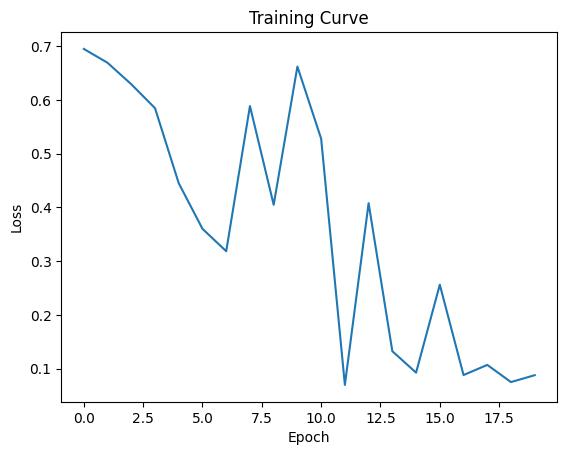

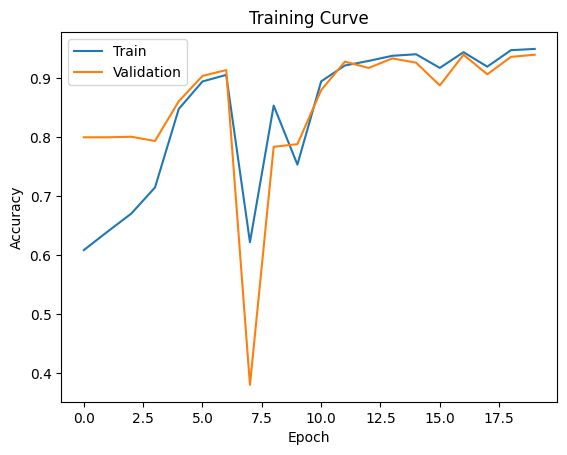

In [ ]:
model = RNN(input_size, 100)
train_rnn_network(model, train_loader, valid_loader, 64, 20, 5e-5)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
# Initial training

# Train Acc: 0.949762
# Val Acc: 0.939910

In [ ]:
# 1st try
# The loss get over-fitting, decrease learning rate
model1 = RNN(input_size, 100)
train_rnn_network(model1, train_loader, valid_loader, 64, 20, 3e-5)

# Train Acc: 0.942046
# Val Acc: 0.934529

In [ ]:
# 2nd try
# The accuracy converges, decrease num_epoch.
model2 = RNN(input_size, 100)
train_rnn_network(model2, train_loader, valid_loader, 64, 15, 5e-5)

# Train Acc: 0.945329
# Val Acc: 0.929148

In [ ]:
# 3rd try
# Try to use max-pooling as the output

class RNN2(nn.Module):
  def __init__(self, input_size, hidden_size):
    self.name = "RNN2"
    super(RNN2, self).__init__()
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, 2)

  def forward(self, x):
    # Look up the embedding
    x = self.emb[x]
    # Set an initial hidden state
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    out = self.fc(torch.max(out, dim=1)[0])
    return out

In [ ]:
model3 = RNN2(input_size, 100)
train_rnn_network(model3, train_loader, valid_loader, 64, 20, 5e-5)

# Train Acc: 0.953866
# Val Acc: 0.943498

In [ ]:
# 4th try
# Try to add a dropout layer for RNN

class RNN3(nn.Module):
    def __init__(self, input_size, hidden_size):
        self.name = "RNN3"
        super(RNN3, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Apply dropout to the output of the RNN
        out = self.dropout(out)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

Epoch 1; Loss 0.703582; Train Acc 0.633394; Val Acc 0.324664
Epoch 2; Loss 0.695475; Train Acc 0.596454; Val Acc 0.252915
Epoch 3; Loss 0.705045; Train Acc 0.720571; Val Acc 0.472646
Epoch 4; Loss 0.584161; Train Acc 0.848301; Val Acc 0.660090
Epoch 5; Loss 0.606598; Train Acc 0.881300; Val Acc 0.895067
Epoch 6; Loss 0.510494; Train Acc 0.917091; Val Acc 0.877130
Epoch 7; Loss 0.449065; Train Acc 0.933180; Val Acc 0.884305
Epoch 8; Loss 0.521975; Train Acc 0.908718; Val Acc 0.914798
Epoch 9; Loss 0.307427; Train Acc 0.927926; Val Acc 0.939910
Epoch 10; Loss 0.222122; Train Acc 0.894434; Val Acc 0.939013
Epoch 11; Loss 0.347891; Train Acc 0.940732; Val Acc 0.898655
Epoch 12; Loss 0.387104; Train Acc 0.943195; Val Acc 0.921973
Epoch 13; Loss 0.346939; Train Acc 0.949762; Val Acc 0.941704
Epoch 14; Loss 0.253009; Train Acc 0.952717; Val Acc 0.933632
Epoch 15; Loss 0.171167; Train Acc 0.947463; Val Acc 0.948879
Epoch 16; Loss 0.165761; Train Acc 0.952553; Val Acc 0.937220
Epoch 17; Loss 0.

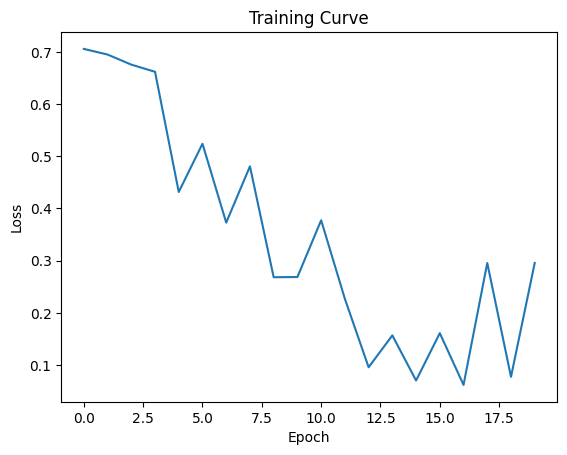

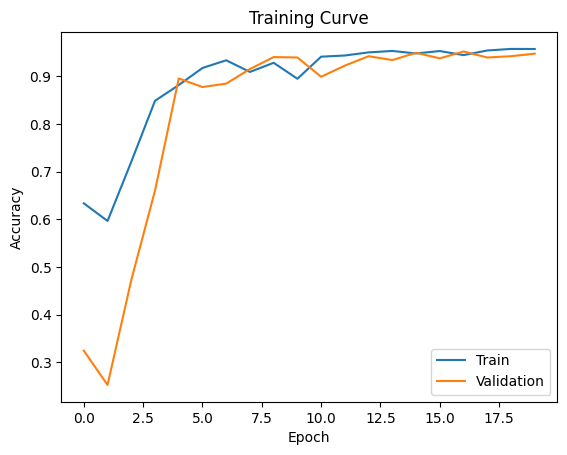

In [ ]:
model4 = RNN3(input_size, 100)
train_rnn_network(model4, train_loader, valid_loader, 64, 20, 5e-5)

# Train Acc: 0.956822
# Val Acc:  0.947085

In [ ]:
# The best is the 4th try to add dropout layer

# Train Acc: 0.956822
# Val Acc:  0.947085

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_false_positive_rate = 1 - get_accuracy(model4, valid_nospam, 64)
valid_false_negative_rate = 1 - get_accuracy(model4, valid_spam, 64)

print("false positive rate:", valid_false_positive_rate)
print("false negative rate:", valid_false_negative_rate)

false positive rate: 0.05093555093555091
false negative rate: 0.07189542483660127


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
# False positive: the message of phone's user received is non-spam
# however, the model detect as a spam message. This lead people maybe
# miss some important imformation.

# False negative: the message of phone's user received is spam messages
# however, the model detect as a non-spam message. This makes people are
# difficult to manage their imformation.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_acc= get_accuracy(model4, test, 64)
print(f"Accuracy: {test_acc * 100:.2f}%")

Accuracy: 96.32%


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_false_positive_rate = 1 - get_accuracy(model4, test_nospam, 64)
test_false_negative_rate = 1 - get_accuracy(model4, test_spam, 64)

print("false positive rate:", test_false_positive_rate)
print("false negative rate:", test_false_negative_rate)

false positive rate: 0.033742331288343586
false negative rate: 0.06617647058823528


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
#text_field.vocab.stoi
msg_stoi = []
i=0
for i in msg:
  msg_stoi.append(torch.tensor(text_field.vocab.stoi[i]))

test_msg = torch.LongTensor(msg_stoi).unsqueeze(dim=0)
prediction = model4(test_msg)
result = float(F.softmax(prediction, dim=1)[0][1])

print("Probability:",result)

Probability: 0.10984163731336594


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
# I think its a easy task to detect spam with RNN.
# With the simple layer of RNN, the model can achieve accuracy
# around 96%, however it is difficult to further decrease the
# rate of false positive and false negative.

# The baseline model could be Bayesian Filtering. a model to discern
# between spam and non-spam emails by analyzing two extensive datasets
# of email messages. The first dataset comprises messages flagged
# as spam and received by a particular site, while the second dataset
# consists of non-spam messages received by the same site.